# Analysis of complex data for Barnett project 

## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from indra.databases import uniprot_client
# pip install git+https://github.com/sorgerlab/indra.git

def uniprot_to_hgnc_name(uniprot_id):
    """Get an HGNC ID from a UniProt."""
    return uniprot_client.get_gene_name(uniprot_id)

In [2]:
abundance_df = pd.read_csv('../data/Abundance_Ultra.csv')
hl_df = pd.read_csv('../data/Half_lives_Ultra.csv')

abundance_df = abundance_df.rename(columns={'Unnamed: 0': 'Protein'})
hl_df = hl_df.rename(columns={'Unnamed: 0': 'Protein'})

# Convert hl_df and abundance_df to long format
abundance_long = pd.melt(abundance_df, id_vars=['Protein'], 
                         var_name='Sample', value_name='Abundance')
hl_long = pd.melt(hl_df, id_vars=['Protein'], 
                  var_name='Sample', value_name='Half_life')

# Join
merged_df = pd.merge(abundance_long, hl_long, on=['Protein', 'Sample'],
                     how='outer')

merged_df['Condition'] = merged_df['Sample'].str[0]
merged_df['logIntensity'] = np.log2(merged_df['Abundance'])

merged_df.head()

,Protein,Sample,Abundance,Half_life,Condition,logIntensity
0,A0A087WRI3,B_R-B2_1_5404,NaN,NaN,B,NaN
1,A0A087WRI3,B_R-B3_1_5405,NaN,NaN,B,NaN
2,A0A087WRI3,B_R-B4_1_5406,NaN,NaN,B,NaN
3,A0A087WRI3,B_R-D5_1_5407,NaN,NaN,B,NaN
4,A0A087WRI3,B_R-D6_1_5408,NaN,NaN,B,NaN


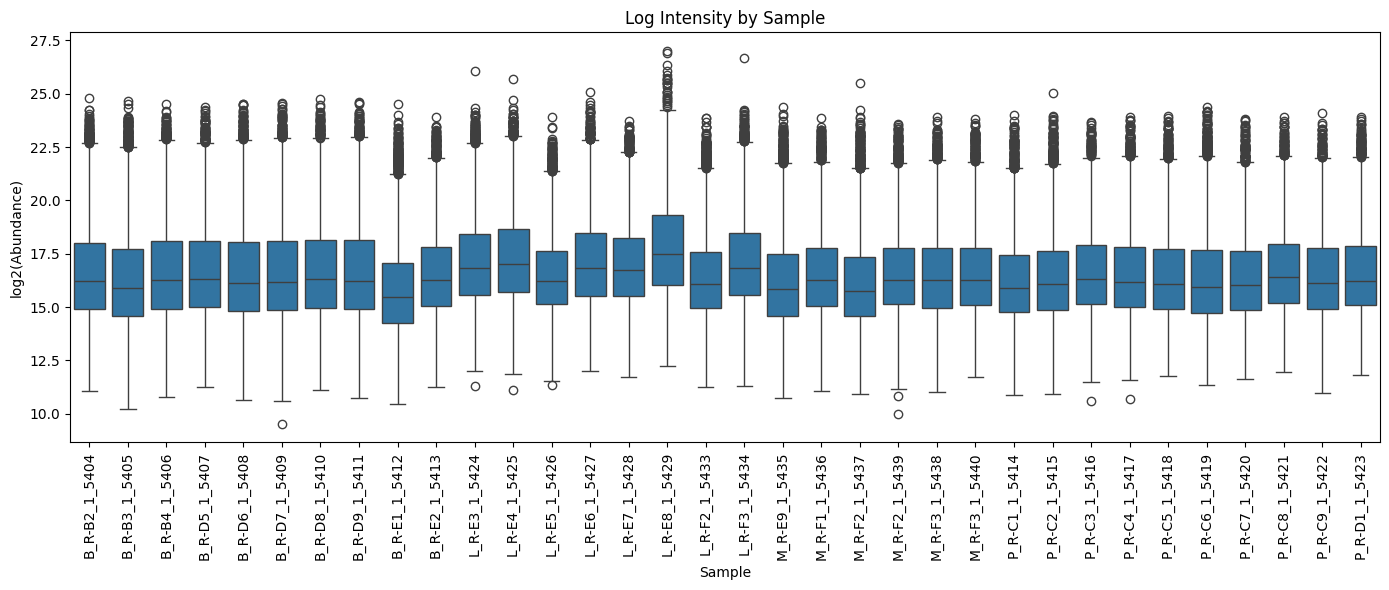

In [3]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_df, x='Sample', y='logIntensity')
plt.xticks(rotation=90)
plt.ylabel('log2(Abundance)')
plt.title('Log Intensity by Sample')
plt.tight_layout()
plt.show()

The QCplots show some pretty significant variance across runs for a DIA 
experiment. We could probably reprocess with some stronger normalization at the 
fragment-level to remove some technical noise in our analysis.



## Run differential analysis

In [4]:
from scipy.stats import t

def fit_one_protein(df):

    """
    Fit a linear model for a single protein's abundance across conditions. 
    Assumes df contains protein-level data in long format with columns:
    - 'Protein': protein identifier (should be the same for all rows)
    - 'Condition': categorical variable indicating experimental condition
    - 'logIntensity': log2-transformed abundance values

    This function performs pairwise comparisons of conditions using an 
    ordinary least squares (OLS) regression model. It computes the log2 
    fold change, t-statistic, standard error, degrees of freedom, and 
    two-sided p-value for each pairwise condition comparison.

    Parameters
    ----------
    df : pandas.DataFrame
        A long-format DataFrame containing columns:
        - 'Protein': protein identifier (should be the same for all rows)
        - 'Condition': categorical variable indicating experimental condition
        - 'logIntensity': log2-transformed abundance values

    Returns
    -------
    results_df : pandas.DataFrame
        DataFrame with one row per pairwise condition comparison, containing:
        - 'Protein': protein identifier
        - 'comparison': string label for the comparison (e.g., 'A-B')
        - 'logFC': log2 fold change between conditions
        - 't_stat': t-statistic for the comparison
        - 'std_error': standard error of the difference
        - 'df': degrees of freedom for the test
        - 'p_value': two-sided p-value for the difference

    Notes
    -----
    - The function removes conditions where all logIntensity values are missing.
    - Uses ordinary least squares (OLS) regression with statsmodels.
    - All pairwise differences between conditions are computed.
    - The reference condition is the first observed in the data.
    """

    # Remove conditions if all data missing
    df = df[df.groupby('Condition')['logIntensity'].transform(lambda x: x.notna().any())]
    
    sm_model = sm.OLS.from_formula('logIntensity ~ Condition', data=df)
    res = sm_model.fit()
    
    params = res.params.copy()
    # Rename 'Intercept' to the reference (dropped) condition
    reference_condition = df['Condition'].unique()[0]
    params[reference_condition] = params.pop('Intercept')
    params[reference_condition] = 0

    params.index = [c.replace('Condition[T.', '').replace(']', '') for c in params.index]
    
    # Replace 'Intercept' with the reference condition in the covariance matrix as well
    cov = res.cov_params()
    reference_condition = df['Condition'].unique()[0]
    if 'Intercept' in cov.index:
        cov = cov.rename(index={'Intercept': reference_condition}, columns={'Intercept': reference_condition})
    cov.index = [c.replace('Condition[T.', '').replace(']', '') for c in cov.index]
    cov.columns = [c.replace('Condition[T.', '').replace(']', '') for c in cov.columns]

    # Calculate all pairwise differences between conditions
    diffs = {}
    covs = {}
    for cond1, cond2 in combinations(params.index, 2):
        # Ensure the comparison label is always in alphabetical order
        conds = sorted([cond1, cond2])
        diff_label = f"{conds[0]}-{conds[1]}"
        diffs[diff_label] = params[conds[0]] - params[conds[1]]
        
        covs[diff_label] = np.sqrt(cov.loc[cond1, cond1] + cov.loc[cond2, cond2] - 2 * cov.loc[cond1, cond2])
    
    
    t_stat = {k: diffs[k] / covs[k] for k in diffs}
    
    dfree = res.df_resid
    p_values = {k: 2 * t.sf(abs(v), dfree) for k, v in t_stat.items()}
    
    results_df = pd.DataFrame({
        'Protein': df['Protein'].iloc[0],
        'comparison': list(t_stat.keys()),
        'logFC': list(diffs.values()),
        't_stat': list(t_stat.values()),
        'std_error': list(covs.values()),
        'df': dfree,
        'p_value': [p_values[k] for k in t_stat.keys()],
    })
    
    return results_df

In [5]:
import warnings
from tqdm.notebook import tqdm

all_proteins = merged_df["Protein"].unique()
results = []
for prot in tqdm(all_proteins, desc="Fitting proteins"):
    df_prot = merged_df[merged_df["Protein"] == prot]
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            res_df = fit_one_protein(df_prot)
        results.append(res_df)
    except Exception:
        continue
all_results_df = pd.concat(results, ignore_index=True)

Fitting proteins:   0%|          | 0/10876 [00:00<?, ?it/s]

In [6]:
# Adjust p-values for each comparison group using Benjamini-Hochberg (FDR)
for comp, group in all_results_df.groupby('comparison'):
    # Only adjust if there are non-null p-values
    mask = group['p_value'].notnull()
    if mask.sum() > 0:
        reject, pvals_corrected, _, _ = multipletests(group.loc[mask, 'p_value'], method='fdr_bh')
        all_results_df.loc[group.loc[mask].index, 'p_adj'] = pvals_corrected


In [7]:
len(all_results_df[all_results_df["p_adj"] < 0.05]) / len(all_results_df)

0.316129889691224

We see about ~1/3rd of the comparisons as differentially abundant with 
$\alpha<.05$. This indicates that there are definitely some changes between 
tissue types across all proteins in the data. We need these differences in 
order to perform our complex analysis

## Compare to CORUM complex db

We are going to look for complexes which appear to be composed of different 
sets of proteins depending on tissue type. We can do this by looking at both 
protein abundances and half lifes. Ideally, if there different forms of a 
complex, we should be able to identify which form we are currently looking at.

### Prepare data for complex analysis

In [8]:
corum_db = pd.read_csv('../data/corum_allComplexes.txt', sep="\t")
corum_complex_genes = corum_db.set_index('complex_name')['subunits_gene_name'].str.split(';').to_dict()

# Convert uniprot names to HGNC names for corum complex genes
all_results_df['Protein'] = all_results_df['Protein'].apply(
    lambda x: uniprot_to_hgnc_name(x))
merged_df['Protein'] = merged_df['Protein'].apply(
    lambda x: uniprot_to_hgnc_name(x))

### Get an idea of which complexes we can analyze

In order to even do this comparison we need to find complexes which have:
- all proteins measured (or at least majority of protein measured)
- differentially abundant proteins (i.e., some proteins in the complex are 
    changing across tissue types)

In [9]:
from tqdm.notebook import tqdm

observed_percentages = {}
diff_abundant_percentages = {}

# Set of all observed proteins (after mapping to HGNC names)
observed_genes = set(all_results_df['Protein'].dropna().unique())
# Set of all differentially abundant proteins (adj p < 0.05)
diff_abundant_genes = set(all_results_df.loc[all_results_df['p_adj'] < 0.05, 'Protein'].dropna().unique())

for complex_name, gene_list in tqdm(corum_complex_genes.items(), 
                                    desc="Processing complexes"):
    # Remove empty strings and strip whitespace
    genes = [g.strip() for g in gene_list if g.strip()]
    if not genes:
        continue
    n_total = len(genes)
    n_observed = sum(g in observed_genes for g in genes)
    n_diff_abundant = sum(g in diff_abundant_genes for g in genes)
    observed_percentages[complex_name] = n_observed / n_total
    diff_abundant_percentages[complex_name] = n_diff_abundant / n_total

print(f"Mean percentage of observed genes per complex: {np.mean(list(observed_percentages.values())):.2%}")
print(f"Mean percentage of differentially abundant genes per complex: {np.mean(list(diff_abundant_percentages.values())):.2%}")

Processing complexes:   0%|          | 0/7603 [00:00<?, ?it/s]

Mean percentage of observed genes per complex: 16.13%
Mean percentage of differentially abundant genes per complex: 10.86%


In [10]:
import random

observed_nonzero = {k: v for k, v in observed_percentages.items() if v > 0}
# Print a few sampled key-value pairs from the dictionary
sample_keys = random.sample(list(observed_nonzero.keys()), 3)
for k in sample_keys:
    print(f"{k}: {observed_nonzero[k]}")

Pde4d-Ptk2-Rack1 complex: 1.0
AKAP13-Rxrb complex: 0.5
Pde1a-Ywhaz complex: 1.0


### Ahr-Arnt complex

In [11]:
print(corum_complex_genes['Ahr-Arnt complex'])
print(f"Percentage observed: {observed_percentages['Ahr-Arnt complex']}")
print(f"Percentage differentially abundant: {diff_abundant_percentages['Ahr-Arnt complex']}")

['Ahr', 'Arnt']
Percentage observed: 1.0
Percentage differentially abundant: 1.0


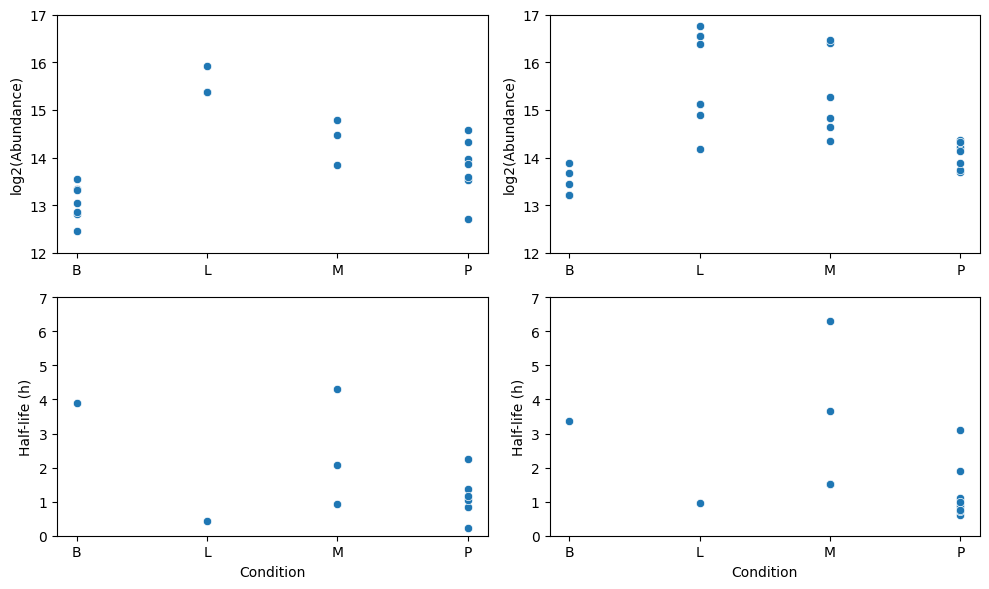

In [12]:
plot_df1 = merged_df[merged_df["Protein"] == "Ahr"]
plot_df2 = merged_df[merged_df["Protein"] == "Arnt"]

fig, ax = plt.subplots(2,2,figsize=(10, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])

# set same y-axis limits for logIntensity and Half_life
# Set consistent y-axis limits for better comparison
ax[0,0].set_ylim(12, 17)
ax[0,1].set_ylim(12, 17)
ax[1,0].set_ylim(0, 7)
ax[1,1].set_ylim(0, 7)

# Improve axis labels and layout
ax[0,0].set_ylabel('log2(Abundance)')
ax[0,1].set_ylabel('log2(Abundance)')
ax[1,0].set_ylabel('Half-life (h)')
ax[1,1].set_ylabel('Half-life (h)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('Condition')
ax[1,1].set_xlabel('Condition')

plt.tight_layout()


Seems like for this complex they may be bound in Liver but not in Brain? M and P
are also questionable.

### Aqp4-Dag1-Dmd-Snta1 complex

In [13]:
print(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'])
print(f"Percentage observed: {observed_percentages['Aqp4-Dag1-Dmd-Snta1 complex']}")
print(f"Percentage differentially abundant: {diff_abundant_percentages['Aqp4-Dag1-Dmd-Snta1 complex']}")

['Aqp4', 'Dag1', 'Dmd', 'Snta1']
Percentage observed: 1.0
Percentage differentially abundant: 1.0


Text(0.5, 1.0, 'Snta1')

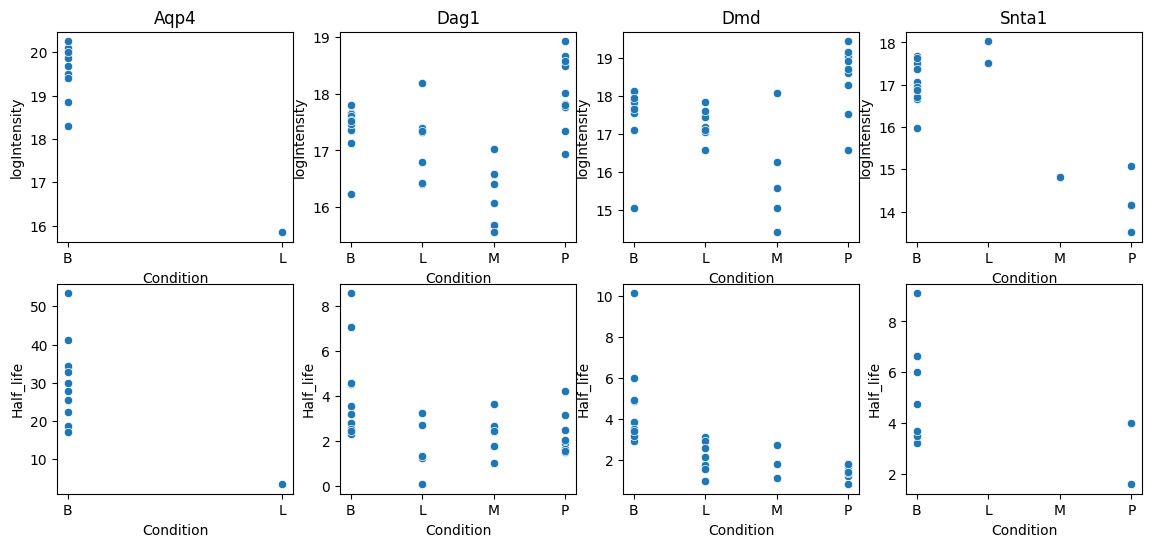

In [14]:
plot_df1 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][0]]
plot_df2 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][1]]
plot_df3 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][2]]
plot_df4 = merged_df[merged_df["Protein"] == corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][3]]

fig, ax = plt.subplots(2,4,figsize=(14, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df3, x='Condition', y='logIntensity', ax=ax[0,2])
sns.scatterplot(data=plot_df4, x='Condition', y='logIntensity', ax=ax[0,3])

sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])
sns.scatterplot(data=plot_df3, x='Condition', y='Half_life', ax=ax[1,2])
sns.scatterplot(data=plot_df4, x='Condition', y='Half_life', ax=ax[1,3])

# set same y-axis limits for logIntensity and Half_life
# ax[0,0].set_ylim(12,17)
# ax[0,1].set_ylim(12,17)
# ax[1,0].set_ylim(0,7)
# ax[1,1].set_ylim(0,7)

ax[0,0].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][0])
ax[0,1].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][1])
ax[0,2].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][2])
ax[0,3].set_title(corum_complex_genes['Aqp4-Dag1-Dmd-Snta1 complex'][3])

## Multiform complexes

### Find complexes with multiple forms

In [15]:
complex_variations = dict()

full_observed_complexes = [k for k, v in observed_percentages.items() if v == 1]
loop_full_complexes = {k: corum_complex_genes[k] for k in full_observed_complexes}

for complex_name, gene_list in tqdm(loop_full_complexes.items(), 
                                    desc="Finding almost complete complexes"):
    variation_list_temp = list()
    
    for compare_complex_name, compare_gene_list in loop_full_complexes.items():
        # Skip self-comparison
        if complex_name == compare_complex_name:
            continue
        
        if len(np.intersect1d(gene_list, compare_gene_list)) / len(gene_list) > 0.5:
            variation_list_temp.append(compare_complex_name)
    
    if len(variation_list_temp) > 0:
        complex_variations[complex_name] = variation_list_temp

Finding almost complete complexes:   0%|          | 0/704 [00:00<?, ?it/s]

In [16]:

# Move keys into values list for complex_variations
complex_variations_with_keys = {k: [k] + v for k, v in complex_variations.items()}
# Convert to list of lists, removing the key
complex_variations_list = list(complex_variations_with_keys.values())
# Remove duplicate sets (complexes with same members in different order)
unique_variations = []
for v in complex_variations_list:
    v_set = set(v)
    if not any(v_set == set(u) for u in unique_variations):
        unique_variations.append(v)
len(unique_variations)

201

There are still some duplicates in this list but it's kinda hard to remove them.

#### APBA1 - CASK - LIN7A

LIN7A can drop out of the complex. There are other forms of this complex as well, 
but we can just look at these three to start.

In [17]:
loop_full_complexes[unique_variations[1][0]]

['Apba1', 'Cask', 'Lin7a']

In [18]:
loop_full_complexes[unique_variations[1][1]]

['Apba1', 'Cask']

Text(0.5, 1.0, 'Lin7a')

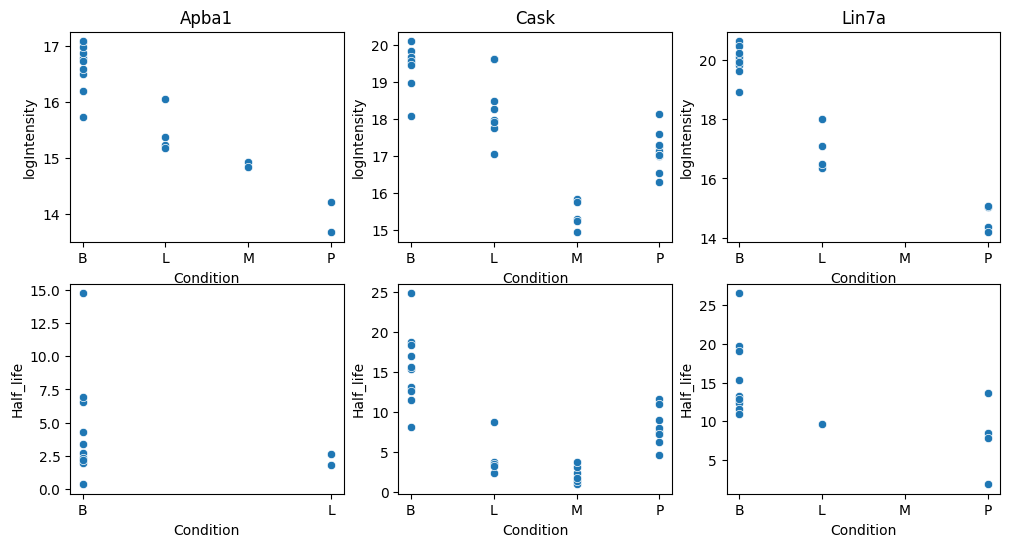

In [19]:
plot_df1 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][0]]
plot_df2 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][1]]
plot_df3 = merged_df[merged_df["Protein"] == loop_full_complexes[unique_variations[1][0]][2]]

fig, ax = plt.subplots(2,3,figsize=(12, 6))
sns.scatterplot(data=plot_df1, x='Condition', y='logIntensity', ax=ax[0,0])
sns.scatterplot(data=plot_df2, x='Condition', y='logIntensity', ax=ax[0,1])
sns.scatterplot(data=plot_df3, x='Condition', y='logIntensity', ax=ax[0,2])

sns.scatterplot(data=plot_df1, x='Condition', y='Half_life', ax=ax[1,0])
sns.scatterplot(data=plot_df2, x='Condition', y='Half_life', ax=ax[1,1])
sns.scatterplot(data=plot_df3, x='Condition', y='Half_life', ax=ax[1,2])

# set same y-axis limits for logIntensity and Half_life
# ax[0,0].set_ylim(12,17)
# ax[0,1].set_ylim(12,17)
# ax[1,0].set_ylim(0,7)
# ax[1,1].set_ylim(0,7)

ax[0,0].set_title(loop_full_complexes[unique_variations[1][0]][0])
ax[0,1].set_title(loop_full_complexes[unique_variations[1][0]][1])
ax[0,2].set_title(loop_full_complexes[unique_variations[1][0]][2])

Doesn't look like much we can distinguish here. Maybe the entire complex is 
disconnected in M.

We need to loop over more of these but vizually inspecting them doesn't really 
work well across many examples. Next step is to design an algorithm to check 
this based on differential abundance changes.

# Create graph of complexes

## Filter for two tissues and calculate obs percentages

In [20]:
missing_pct = merged_df.groupby('Condition')['logIntensity'].apply(lambda x: x.isna().mean())
print(missing_pct)

Condition
B    0.276958
L    0.396205
M    0.329165
P    0.502409
Name: logIntensity, dtype: float64


We will use B and M because they have the lowest missing percentage (keep things easy).

In [21]:
bm_results = all_results_df[all_results_df['comparison'] == 'B-M']
bm_percentages = {}

# Set of all observed proteins (after mapping to HGNC names)
observed_genes = set(bm_results['Protein'].dropna().unique())
# Set of all differentially abundant proteins (adj p < 0.05)
diff_abundant_genes = set(bm_results.loc[bm_results['p_adj'] < 0.05, 'Protein'].dropna().unique())

for complex_name, gene_list in tqdm(corum_complex_genes.items(), 
                                    desc="Processing complexes"):
    # Remove empty strings and strip whitespace
    genes = [g.strip() for g in gene_list if g.strip()]
    if not genes:
        continue
    n_total = len(genes)
    n_observed = sum(g in observed_genes for g in genes)
    n_diff_abundant = sum(g in diff_abundant_genes for g in genes)
    bm_percentages[complex_name] = n_observed / n_total

print(f"Mean percentage of observed genes per complex: {np.mean(list(bm_percentages.values())):.2%}")


Processing complexes:   0%|          | 0/7603 [00:00<?, ?it/s]

Mean percentage of observed genes per complex: 13.42%


Only grab complexes which were fully observed

In [22]:
bm_nonzero = {k: v for k, v in bm_percentages.items() if v == 1}

In [23]:
axin_keys = [k for k in bm_nonzero.keys() if "Axin" in k]
print(axin_keys)

['Axin-GSK-3-beta-beta-catenin complex', 'Axin1-Map3k1 complex', 'Axin1-Map3k4 complex', 'Axin-GSK-3-beta complex', 'Axin-GSK-3-alpha complex', 'Axin-beta-catenin complex', 'Daxx-Axin complex', 'Axin-Dvl-Gsk complex', 'Axin1-Ctnnb1-Lrp5 complex', 'Axin-Apc-Catnb-Gsk3b-Macf1 complex', 'Axin-Csnk1e-Dvl1 complex']


## Testable example

Test out an algorithm on a small subset that we can vizualize easier

In [24]:
example_complex_list = [
    'Axin1-Map3k1 complex',
    'Axin-GSK-3-alpha complex',
    'Axin-GSK-3-beta complex',
    'Axin-GSK-3-beta-beta-catenin complex']

subset_genes = {k: corum_complex_genes[k] for k in example_complex_list}
subset_genes

{'Axin1-Map3k1 complex': ['Axin1', 'Map3k1'],
 'Axin-GSK-3-alpha complex': ['Axin1', 'Gsk3a'],
 'Axin-GSK-3-beta complex': ['Axin1', 'Gsk3b'],
 'Axin-GSK-3-beta-beta-catenin complex': ['Axin1', 'Ctnnb1', 'Gsk3b']}

### Create graph

In [ ]:
# Initialize an empty undirected graph
G = nx.Graph()

for complex, genes in subset_genes.items():
    # Add edges between all pairs of genes in the complex
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            G.add_edge(genes[i], genes[j], complex=complex)

In [26]:
G.nodes

NodeView(('Axin1', 'Map3k1', 'Gsk3a', 'Gsk3b', 'Ctnnb1'))

### ID edges

In [27]:
bm_results[bm_results["Protein"].isin(G.nodes)]

,Protein,comparison,logFC,t_stat,std_error,df,p_value,p_adj
2495,Axin1,B-M,-0.294811,-0.519538,0.567449,21.0,6.088190e-01,0.741893
8849,Map3k1,B-M,-2.294957,-1.934127,1.186560,6.0,1.012631e-01,0.217859
12333,Ctnnb1,B-M,4.312800,6.333680,0.680931,30.0,5.507728e-07,0.000023
13079,Gsk3a,B-M,2.311640,4.434313,0.521307,27.0,1.391504e-04,0.001473
44012,Gsk3b,B-M,2.312244,3.112069,0.742992,26.0,4.475976e-03,0.021568


In [29]:
# Loop over nodes in G and remove all edges for nodes where bm_results p_value < 0.1
nodes_to_isolate = set()
for node in G.nodes:
    node_results = bm_results[bm_results["Protein"] == node]
    if (node_results["p_value"].values[0] < 0.2) & (node_results["logFC"].values[0] > 0):
        nodes_to_isolate.add(node)

B_graph = G.copy()
for node in nodes_to_isolate:
    B_graph.remove_edges_from(list(G.edges(node)))

nodes_to_isolate = set()
for node in G.nodes:
    node_results = bm_results[bm_results["Protein"] == node]
    if (node_results["p_value"].values[0] < 0.2) & (node_results["logFC"].values[0] < 0):
        nodes_to_isolate.add(node)

M_graph = G.copy()
for node in nodes_to_isolate:
    M_graph.remove_edges_from(list(G.edges(node)))


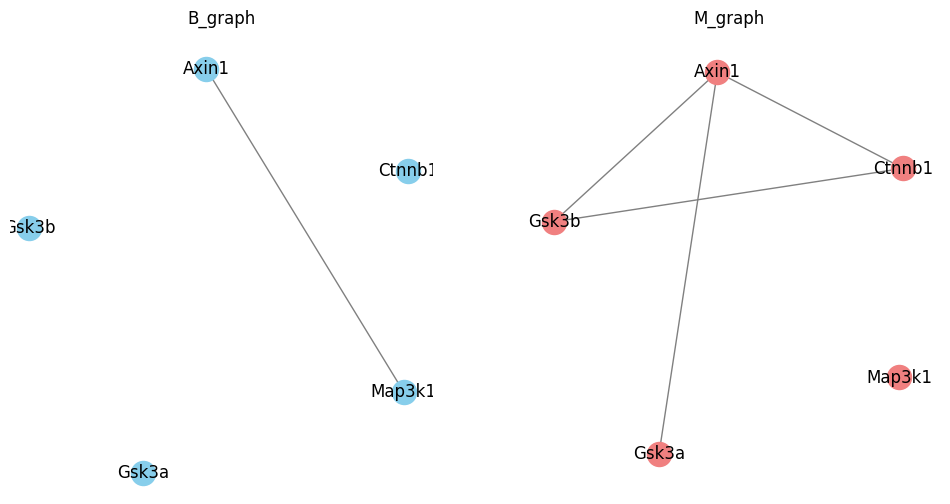

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Use spring_layout with higher 'k' value to bring nodes closer together
pos_B = nx.spring_layout(B_graph, k=20, seed=42)
pos_M = nx.spring_layout(M_graph, k=20, seed=42)
nx.draw(B_graph, pos=pos_B, with_labels=True, ax=ax[0], node_color='skyblue', edge_color='gray')
ax[0].set_title('B_graph')

nx.draw(M_graph, pos=pos_M, with_labels=True, ax=ax[1], node_color='lightcoral', edge_color='gray')
ax[1].set_title('M_graph')

# plt.tight_layout()
plt.show()

In [31]:
# For each connected component in B_graph, identify which complexes from example_complex_list are present
connected_nodes = list(nx.connected_components(B_graph))
complexes_in_components = []

for component in connected_nodes:
    found_complexes = []
    for complex_name in example_complex_list:
        genes = set(subset_genes[complex_name])
        if genes.issubset(component):
            found_complexes.append(complex_name)
    complexes_in_components.append(found_complexes)

for idx, complexes in enumerate(complexes_in_components):
    print(f"Component {idx+1}: {complexes}")

Component 1: ['Axin1-Map3k1 complex']
Component 2: []
Component 3: []
Component 4: []


In [ ]:
# For each connected component in M_graph, identify which complexes from example_complex_list are present
connected_nodes = list(nx.connected_components(M_graph))
complexes_in_components = []

for component in connected_nodes:
    found_complexes = []
    for complex_name in example_complex_list:
        genes = set(subset_genes[complex_name])
        if genes.issubset(component):
            found_complexes.append(complex_name)
    complexes_in_components.append(found_complexes)

for idx, complexes in enumerate(complexes_in_components):
    print(f"Component {idx+1}: {complexes}")

Component 1: ['Axin-GSK-3-alpha complex', 'Axin-GSK-3-beta complex', 'Axin-GSK-3-beta-beta-catenin complex']
Component 2: []


We can clearly see that there is a difference in what complexes are present between tissue types

## Expand example to include more complexes

There are many more complexes beyond the toy example. Still only look at B vs M.

In [54]:
subset_genes = {k: corum_complex_genes[k] for k in bm_nonzero.keys()}

# Initialize an empty undirected graph
G = nx.Graph()

for complex, genes in subset_genes.items():
    # Add edges between all pairs of genes in the complex
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if genes[i] and genes[j]:  # Ensure neither gene is an empty string
                G.add_edge(genes[i], genes[j], complex=complex)

In [56]:
# Loop over nodes in G and remove all edges for nodes where bm_results p_value < 0.1
nodes_to_isolate = set()
for node in G.nodes:
    node_results = bm_results[bm_results["Protein"] == node]
    if (node_results["p_value"].values[0] < 0.2) & (node_results["logFC"].values[0] > 0):
        nodes_to_isolate.add(node)

B_graph = G.copy()
for node in nodes_to_isolate:
    B_graph.remove_edges_from(list(G.edges(node)))

nodes_to_isolate = set()
for node in G.nodes:
    node_results = bm_results[bm_results["Protein"] == node]
    if (node_results["p_value"].values[0] < 0.2) & (node_results["logFC"].values[0] < 0):
        nodes_to_isolate.add(node)

M_graph = G.copy()
for node in nodes_to_isolate:
    M_graph.remove_edges_from(list(G.edges(node)))


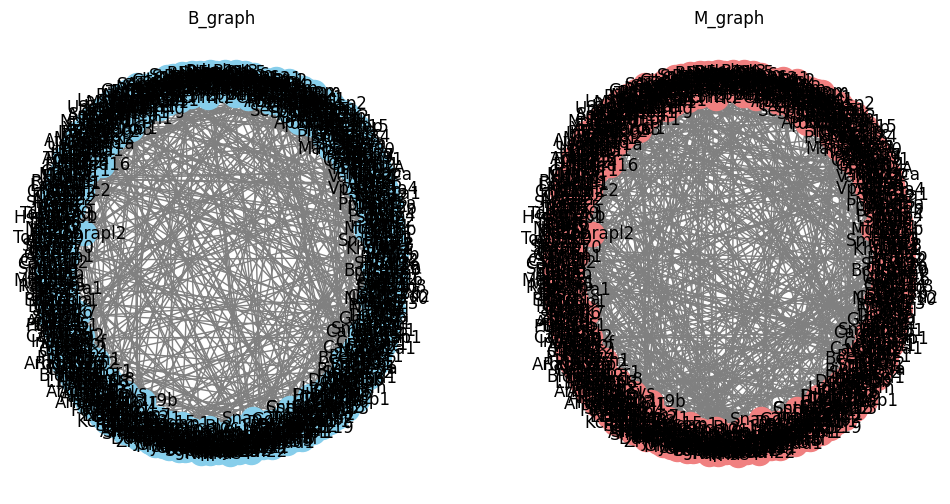

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Use spring_layout with higher 'k' value to bring nodes closer together
pos_B = nx.spring_layout(B_graph, k=20, seed=42)
pos_M = nx.spring_layout(M_graph, k=20, seed=42)
nx.draw(B_graph, pos=pos_B, with_labels=True, ax=ax[0], node_color='skyblue', edge_color='gray')
ax[0].set_title('B_graph')

nx.draw(M_graph, pos=pos_M, with_labels=True, ax=ax[1], node_color='lightcoral', edge_color='gray')
ax[1].set_title('M_graph')

# plt.tight_layout()
plt.show()

The graphs are not helpful because there are too many nodes. We can filter it down based on what complexes are present.

In [67]:
# For each connected component in B_graph, identify which complexes are present
connected_nodes = list(nx.connected_components(B_graph))
complexes_in_components = []

for component in connected_nodes:
    found_complexes = []
    for complex_name in bm_nonzero.keys():
        genes = set(subset_genes[complex_name])
        if genes.issubset(component):
            found_complexes.append(complex_name)
    complexes_in_components.append(found_complexes)

for idx, complexes in enumerate(complexes_in_components):
    print(f"Component {idx+1}: {complexes}")
    
b_complexes = [complex_name for complexes in complexes_in_components for complex_name in complexes]

Component 1: ['Ahr-Arnt complex', 'Ahr-Aip-Hsp90 complex', 'Aip-Pde2a complex']
Component 2: ['BLOC-2 (biogenesis of lysosome-related organelles complex 2)']
Component 3: []
Component 4: []
Component 5: []
Component 6: []
Component 7: []
Component 8: []
Component 9: []
Component 10: ['SNARE complex (Bet1, Gosr1, Gosr2, Scfd1, Sec22b, Stx5)', 'SNARE complex (Stx5, Gosr2, Sec22b, Bet1)', 'SNARE complex (Bet1,Stx5, Vamp7, Vti1a)', 'SNARE complex (Gosr1, GS15, Stx5)', 'p97-Ufd1-Npl4 complex', 'Ufd1-Npl4 complex', 'Vcp homohexamer', 'Ngly1-Vcp-Ubxn1 complex', 'Hdac6-Plaa-Vcp complex']
Component 11: ['Baz2a-Smarca5 complex']
Component 12: []
Component 13: []
Component 14: []
Component 15: []
Component 16: []
Component 17: []
Component 18: ['Crebbp-Ep300-Ncoa1 complex', 'SWAP complex', 'Sin3-Hdac1-Sds3 complex', 'PYR complex', 'Tis7-Sin3-Hdac1-Ncor1-Sap30 complex', 'DNMT1-HDAC2-DMAP1 complex', 'E2f5-Hdac1-Rbl2 complex', 'Stat3-Crebbp complex', 'Smad1-Notch1-p300-Pcaf complex', 'Smad3-Smad4 co

In [71]:
# For each connected component in M_graph, identify which complexes are present
connected_nodes = list(nx.connected_components(M_graph))
complexes_in_components = []

for component in connected_nodes:
    found_complexes = []
    for complex_name in bm_nonzero.keys():
        genes = set(subset_genes[complex_name])
        if genes.issubset(component):
            found_complexes.append(complex_name)
    complexes_in_components.append(found_complexes)

for idx, complexes in enumerate(complexes_in_components):
    print(f"Component {idx+1}: {complexes}")

m_complexes = [complex_name for complexes in complexes_in_components for complex_name in complexes]

Component 1: []
Component 2: []
Component 3: []
Component 4: []
Component 5: []
Component 6: ['CASK-MINT complex', 'Dystrophin associated complex DPC (Dmd, Dtnb), brain-derived', 'Dystrobrevin-syntrophin complex, brain-derived', 'Muscle-derived dystrobrevin-syntrophin complex', 'Kir4.1-dystrophin complex, retinal Mueller cells', 'Kir4.1-alpha-1-syntrophin complex', 'Kir4.1-beta-dystroglycan complex', 'Kir4.1-dystrobrevin complex, retinal Mueller cells', 'Dystrophin-associated glycoprotein complex DGC (Dag1, Dp71f, Sgcd, Snta1), retinal glia cells', 'Camk2-Dlg4-Mpdz-Syngap1 complex', 'Kir4.1-dystrophin complex', 'Snap25-caveolin complex', 'Cdh5-Ctnna1-Ctnnb1-Pard3 complex', 'SNARE complex (Snap29, Stx1a)', 'GluR1-cadherin-catenin complex', 'PAR-3-aPKC-Tiam2 complex', 'PAR-3-aPKC-Tiam1 complex', 'Kif3a-Pard3-Prkci complex', 'Par3-Apc-Kif3a complex', 'Scrib-Git1-Arhgef7 complex', 'Scrib-APC-beta-catenin complex', 'SNARE complex (Stx1a, Snap25, Stxbp5)', 'Ocrl-Cdc42 complex', 'Kif5b-Dtnb c

In [73]:
# Find intersection and differences between b_complexes and m_complexes
b_set = set(b_complexes)
m_set = set(m_complexes)

intersection = b_set & m_set
only_in_b = b_set - m_set
only_in_m = m_set - b_set

print(f"Number of complexes in both B and M: {len(intersection)}")
print(f"Number of complexes only in B: {len(only_in_b)}")
print(f"Number of complexes only in M: {len(only_in_m)}")

Number of complexes in both B and M: 59
Number of complexes only in B: 121
Number of complexes only in M: 212


### Find some interesting complex pairs

In [ ]:
# Find complexes in only_in_m that share at least one protein with a complex in only_in_b, but are not the same complex
shared_protein_complexes = []

for m_complex in only_in_m:
    m_proteins = set(subset_genes.get(m_complex, []))
    for b_complex in only_in_b:
        b_proteins = set(subset_genes.get(b_complex, []))
        # Check for shared proteins but different complex names
        if m_complex != b_complex and m_proteins & b_proteins:
            shared_protein_complexes.append((m_complex, b_complex, list(m_proteins & b_proteins)))

# Remove duplicates
unique_shared = []
seen = set()
for item in shared_protein_complexes:
    key = tuple(sorted([item[0], item[1]]))
    if key not in seen:
        unique_shared.append(item)
        seen.add(key)

# Print results
for m_complex, b_complex, shared in unique_shared:
    print(f"M only: {m_complex}\nB only: {b_complex}\nShared proteins: {shared}\n")

M only: Cd2ap-Fyn complex
B only: Cbl-Cd2ap-Flt1 complex
Shared proteins: ['Cd2ap']

M only: Cd2ap-Fyn complex
B only: Cbl-Cd2ap complex
Shared proteins: ['Cd2ap']

M only: Akt2-Pik3cd-Pik3r2 complex
B only: Pik3ap1-Pik3cd-Pik3r1 complex
Shared proteins: ['Pik3cd']

M only: Akt2-Pik3cd-Pik3r2 complex
B only: Cbl-Pik3cd-Pik3r1 complex
Shared proteins: ['Pik3cd']

M only: Grb2-mSos1 complex
B only: Cbl-Frs2-Grb2 complex
Shared proteins: ['Grb2']

M only: Grb2-mSos1 complex
B only: Shc-Ship-Grb2 complex, IL-3-stimulated
Shared proteins: ['Grb2']

M only: Grb2-mSos1 complex
B only: Cd22-Ship-Grb2-Shc complex
Shared proteins: ['Grb2']

M only: Crkl-Pik3cd-Pik3r1 complex
B only: Pik3ap1-Pik3cd-Pik3r1 complex
Shared proteins: ['Pik3r1', 'Pik3cd']

M only: Crkl-Pik3cd-Pik3r1 complex
B only: Cbl-Pik3cd-Pik3r1 complex
Shared proteins: ['Pik3r1', 'Pik3cd']

M only: Axin-GSK-3-beta-beta-catenin complex
B only: Axin1-Map3k1 complex
Shared proteins: ['Axin1']

M only: MCC complex (p85alpha, p110alph

### GRB2 complexes

In [77]:
grb_keys = [k for k in bm_nonzero.keys() if "Grb2" in k]
grb_proteins = set()
for k in grb_keys:
    grb_proteins.update(subset_genes[k])
print(grb_proteins)

{'Pld2', 'Syk', 'Frs2', 'Shc1', 'Ptk2b', 'Sos1', 'Ptpn6', 'Cbl', 'Was', 'Cd22', 'Grb2', 'Inpp5d', 'Ptpn11'}


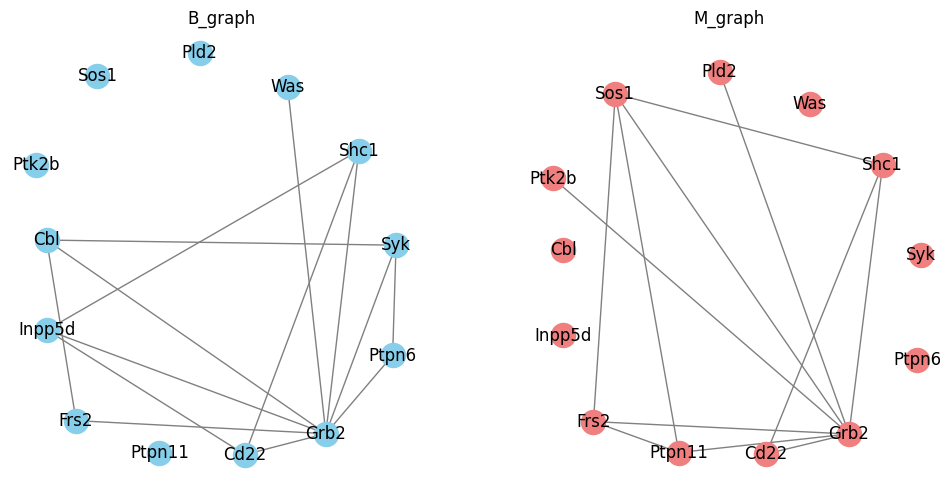

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Create subgraphs containing only nodes in grb_proteins
B_grb_subgraph = B_graph.subgraph(grb_proteins)
M_grb_subgraph = M_graph.subgraph(grb_proteins)

# Use spring_layout with higher 'k' value to bring nodes closer together
pos_B = nx.spring_layout(B_grb_subgraph, k=20, seed=42)
pos_M = nx.spring_layout(M_grb_subgraph, k=20, seed=42)

nx.draw(B_grb_subgraph, pos=pos_B, with_labels=True, ax=ax[0], node_color='skyblue', edge_color='gray')
ax[0].set_title('B_graph')

nx.draw(M_grb_subgraph, pos=pos_M, with_labels=True, ax=ax[1], node_color='lightcoral', edge_color='gray')
ax[1].set_title('M_graph')

# plt.tight_layout()
plt.show()

Again we can see different complexes forming between the subgraphs.

## Next steps

- Expand analysis to more tissue types
- Test with different p-values (more or less stringent)
- Deal with missing values (more of a problem with more tissues)
- Expand to INDRA graph
    - This kind of analysis would work really well with INDRA